In [37]:
import os
import glob
import math
import numpy as np
import torch
import torchaudio
import soundfile as sf
import matplotlib.pyplot as plt
from pysepm import pesq, stoi, composite  # pysepm functions
from IPython.display import Audio, display

# CONFIGURATION & PARAMETERS
SAMPLE_RATE = 16000            # Model expects 16 kHz
TARGET_AUDIO_LENGTH = 2.0      # seconds (expected duration per sample)
TARGET_NUM_SAMPLES = int(SAMPLE_RATE * TARGET_AUDIO_LENGTH)

# Model parameters (must match training)
L = 5           # number of layers
K = 8           # kernel size
S_conv = 4      # stride
RESAMPLE_FACTOR = 4

def compute_valid_length(base_length, depth, kernel_size, stride, resample):
    L_val = math.ceil(base_length * resample)
    for _ in range(depth):
        L_val = math.ceil((L_val - kernel_size) / stride) + 1
        L_val = max(L_val, 1)
    for _ in range(depth):
        L_val = (L_val - 1) * stride + kernel_size
    return int(math.ceil(L_val / resample))

# The model’s fixed input length.
FRAME_LENGTH = compute_valid_length(TARGET_NUM_SAMPLES, L, K, S_conv, RESAMPLE_FACTOR)

# Directories with test audio files (adjust these paths)
NOISY_TEST_DIR = r"c:\Users\Andrei\Desktop\Proiect Licenta\datasets\DS_10283_2791\noisy_trainset_56spk_wav"
CLEAN_TEST_DIR = r"c:\Users\Andrei\Desktop\Proiect Licenta\datasets\DS_10283_2791\clean_trainset_56spk_wav"

print("Configuration Complete:")
print(f"SAMPLE_RATE: {SAMPLE_RATE}, FRAME_LENGTH: {FRAME_LENGTH}")

Configuration Complete:
SAMPLE_RATE: 16000, FRAME_LENGTH: 32085


In [ ]:
# MODEL DEFINITION: Import your model class.
# This assumes you have a file "model_def.py" with class CausalDemucsSplit defined.
from model_def import CausalDemucsSplit

# LOAD THE MODEL (best_model_ms_snsd.pth)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CausalDemucsSplit(chin=1, chout=1, hidden=48, depth=5, kernel_size=K, stride=S_conv,
                          causal=True, resample=RESAMPLE_FACTOR, normalize=False, glu=True).to(device)
checkpoint = torch.load("best_model_ms_snsd_split.pth", map_location=device)
model.load_state_dict(checkpoint)
model.eval()
print("Model loaded for evaluation.")


Model loaded for evaluation.


In [39]:
def pad_or_crop(audio, target_length):
    """Crop or zero-pad a 1D numpy array to exactly target_length samples."""
    audio = np.atleast_1d(audio)
    current_length = audio.shape[0]
    if current_length > target_length:
        return audio[:target_length]
    elif current_length < target_length:
        pad_amt = target_length - current_length
        return np.concatenate([audio, np.zeros((pad_amt,), dtype=audio.dtype)])
    else:
        return audio
    
#normalize the audio
def external_normalize(audio, eps=1e-3):
    """
    Normalize the audio externally.
    Returns:
      normalized_audio: audio divided by (std + eps)
      std: computed per-sample standard deviation (used later for re-scaling)
    """
    mono = audio.mean(dim=1, keepdim=True)
    std = mono.std(dim=-1, keepdim=True)
    normalized = audio / (std + eps)
    return normalized, std

def process_audio_segment(segment):
    """
    Process a 1D numpy array (of length FRAME_LENGTH) using the PyTorch model.
    Returns the enhanced audio as a 1D numpy array.
    """
    tensor_in = torch.from_numpy(segment.astype(np.float32)).unsqueeze(0).unsqueeze(0).to(device)
    normalized, std = external_normalize(tensor_in)
    with torch.no_grad():
        enhanced = model(normalized)
    enhanced = enhanced * std
    enhanced = enhanced.squeeze().cpu().numpy()
    return enhanced

def plot_spectrogram(audio, sr, title="Spectrogram"):
    """
    Plot the spectrogram of the given 1D audio signal.
    """
    plt.figure(figsize=(10, 4))
    # Compute and plot spectrogram.
    spec, freqs, times, im = plt.specgram(audio, NFFT=512, Fs=sr, noverlap=256, cmap='viridis')
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title(title)
    plt.colorbar(label="Intensity (dB)")
    plt.show()

def play_audio(audio, sr):
    """Display an audio player to play the given 1D audio signal."""
    display(Audio(data=audio, rate=sr))


Processing file: noisy4_SNRdb_0.0_clnsp4.wav
Metrics for noisy4_SNRdb_0.0_clnsp4.wav:
PESQ: 1.063
STOI: 0.718
CSIG: 1.977, CBAK: 1.902, COVL: 1.462


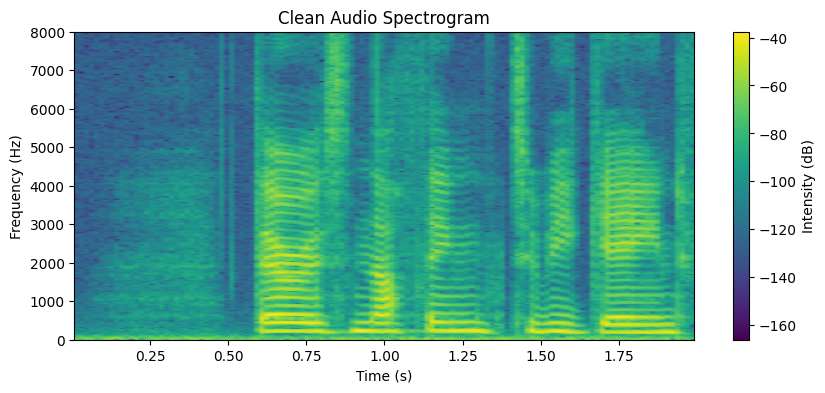

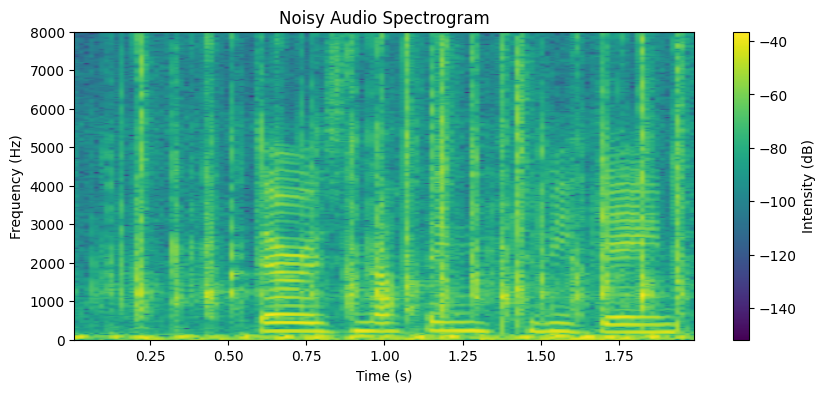

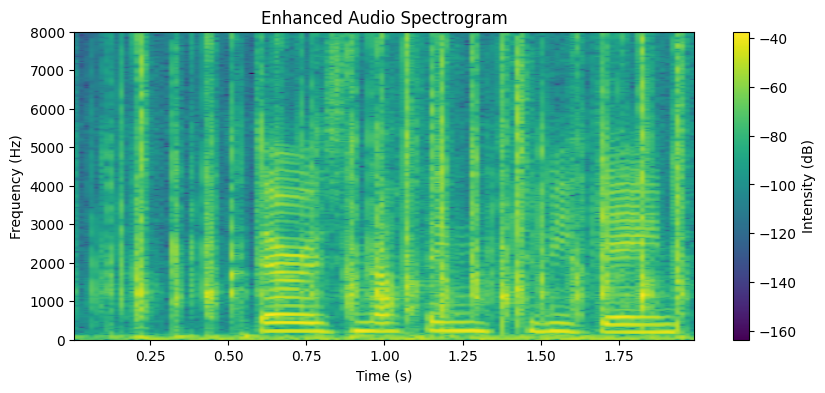

Clean Audio:


Noisy Audio:


Enhanced Audio:


In [40]:
# For demonstration, process one test file pair.
# You may loop over all files as in your script later.
test_noisy_files = sorted(glob.glob(os.path.join(NOISY_TEST_DIR, "*.wav")))
test_clean_files = sorted(glob.glob(os.path.join(CLEAN_TEST_DIR, "*.wav")))

if len(test_noisy_files) == 0:
    raise ValueError("No test files found! Please adjust the test directories.")

# Let's pick the first test file.
#index = 54
#noisy_path = test_noisy_files[index]
#clean_path = test_clean_files[index]

noisy_path = r"noisy4_SNRdb_0.0_clnsp4.wav"
clean_path = r"clnsp4.wav"

print("Processing file:", os.path.basename(noisy_path))

# Load the test audio using torchaudio.
noisy_waveform, sr_noisy = torchaudio.load(noisy_path)
clean_waveform, sr_clean = torchaudio.load(clean_path)
# Resample if needed.
if sr_noisy != SAMPLE_RATE:
    noisy_waveform = torchaudio.transforms.Resample(sr_noisy, SAMPLE_RATE)(noisy_waveform)
if sr_clean != SAMPLE_RATE:
    clean_waveform = torchaudio.transforms.Resample(sr_clean, SAMPLE_RATE)(clean_waveform)
# Convert to mono.
noisy_waveform = noisy_waveform.mean(dim=0).numpy()
clean_waveform = clean_waveform.mean(dim=0).numpy()

# Crop or pad to FRAME_LENGTH.
noisy_segment = pad_or_crop(noisy_waveform, FRAME_LENGTH)
clean_segment = pad_or_crop(clean_waveform, FRAME_LENGTH)
# Process the noisy segment with the model.

enhanced_segment = process_audio_segment(noisy_segment)

# Compute metrics using pysepm.
try:
    pesq_score = pesq(clean_segment, enhanced_segment, SAMPLE_RATE)
except Exception as e:
    print("Error computing PESQ:", e)
    pesq_score = np.nan

try:
    stoi_score = stoi(clean_segment, enhanced_segment, SAMPLE_RATE)
except Exception as e:
    print("Error computing STOI:", e)
    stoi_score = np.nan

try:
    csig, cbak, covl = composite(clean_segment, enhanced_segment, SAMPLE_RATE)
except Exception as e:
    print("Error computing composite metrics:", e)
    csig, cbak, covl = (np.nan, np.nan, np.nan)

print(f"Metrics for {os.path.basename(noisy_path)}:")
print(f"PESQ: {pesq_score[1]:.3f}")
print(f"STOI: {stoi_score:.3f}")
print(f"CSIG: {csig:.3f}, CBAK: {cbak:.3f}, COVL: {covl:.3f}")

# Plot spectrograms.
plot_spectrogram(clean_segment, SAMPLE_RATE, title="Clean Audio Spectrogram")
plot_spectrogram(noisy_segment, SAMPLE_RATE, title="Noisy Audio Spectrogram")
plot_spectrogram(enhanced_segment, SAMPLE_RATE, title="Enhanced Audio Spectrogram")

# Play audio using IPython display.
print("Clean Audio:")
play_audio(clean_segment, SAMPLE_RATE)
print("Noisy Audio:")
play_audio(noisy_segment, SAMPLE_RATE)
print("Enhanced Audio:")
play_audio(enhanced_segment, SAMPLE_RATE)


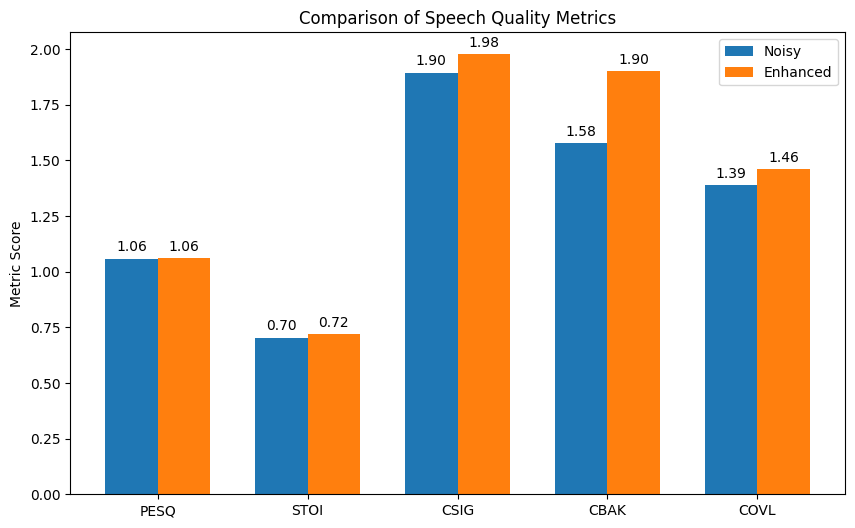

In [41]:
def extract_score(score):
    """
    If score is a tuple with more than one element, return the element at index 1.
    Otherwise, return score.
    """
    if isinstance(score, tuple) and len(score) > 1:
        return score[1]
    return score

# Compute metrics for the noisy signal.
try:
    noisy_pesq_result = pesq(clean_segment, noisy_segment, SAMPLE_RATE)
    noisy_pesq = extract_score(noisy_pesq_result)
except Exception as e:
    print("Error computing noisy PESQ:", e)
    noisy_pesq = np.nan

try:
    noisy_stoi_result = stoi(clean_segment, noisy_segment, SAMPLE_RATE)
    noisy_stoi = extract_score(noisy_stoi_result)
except Exception as e:
    print("Error computing noisy STOI:", e)
    noisy_stoi = np.nan

try:
    noisy_csig, noisy_cbak, noisy_covl = composite(clean_segment, noisy_segment, SAMPLE_RATE)
except Exception as e:
    print("Error computing noisy composite:", e)
    noisy_csig, noisy_cbak, noisy_covl = (np.nan, np.nan, np.nan)

# Compute metrics for the enhanced signal.
try:
    enhanced_pesq_result = pesq(clean_segment, enhanced_segment, SAMPLE_RATE)
    enhanced_pesq = extract_score(enhanced_pesq_result)
except Exception as e:
    print("Error computing enhanced PESQ:", e)
    enhanced_pesq = np.nan

try:
    enhanced_stoi_result = stoi(clean_segment, enhanced_segment, SAMPLE_RATE)
    enhanced_stoi = extract_score(enhanced_stoi_result)
except Exception as e:
    print("Error computing enhanced STOI:", e)
    enhanced_stoi = np.nan

try:
    enhanced_csig, enhanced_cbak, enhanced_covl = composite(clean_segment, enhanced_segment, SAMPLE_RATE)
except Exception as e:
    print("Error computing enhanced composite:", e)
    enhanced_csig, enhanced_cbak, enhanced_covl = (np.nan, np.nan, np.nan)

# Create lists of metrics.
metrics_names = ['PESQ', 'STOI', 'CSIG', 'CBAK', 'COVL']
noisy_metrics = [noisy_pesq, noisy_stoi, noisy_csig, noisy_cbak, noisy_covl]
enhanced_metrics = [enhanced_pesq, enhanced_stoi, enhanced_csig, enhanced_cbak, enhanced_covl]

# Plot grouped bar chart.
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(metrics_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, noisy_metrics, width, label='Noisy')
rects2 = ax.bar(x + width/2, enhanced_metrics, width, label='Enhanced')

ax.set_ylabel('Metric Score')
ax.set_title('Comparison of Speech Quality Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()

# Annotate bars with values.
for rect in rects1 + rects2:
    height = rect.get_height()
    if not np.isnan(height):
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')
plt.show()


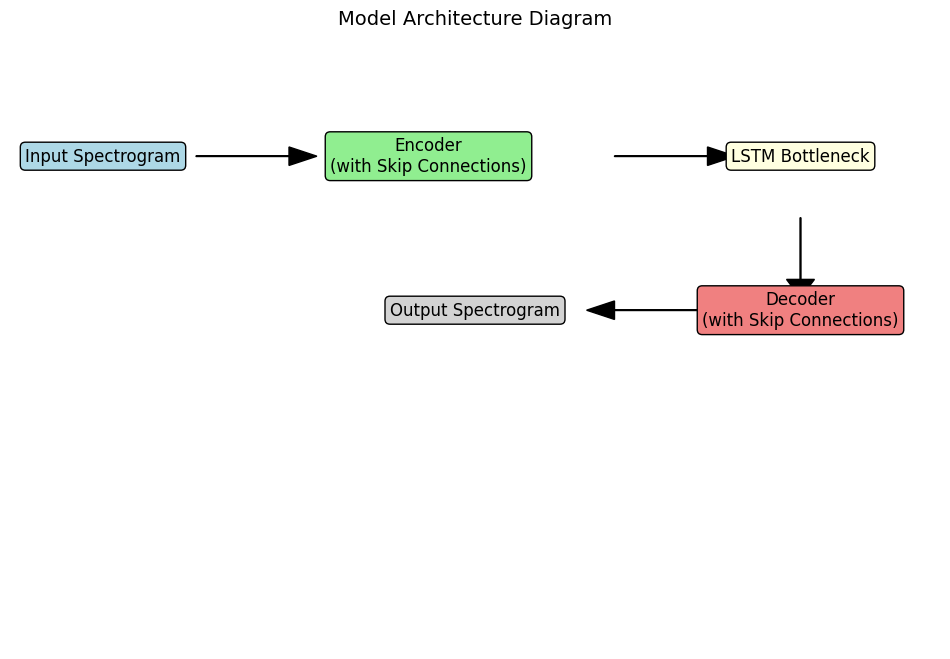

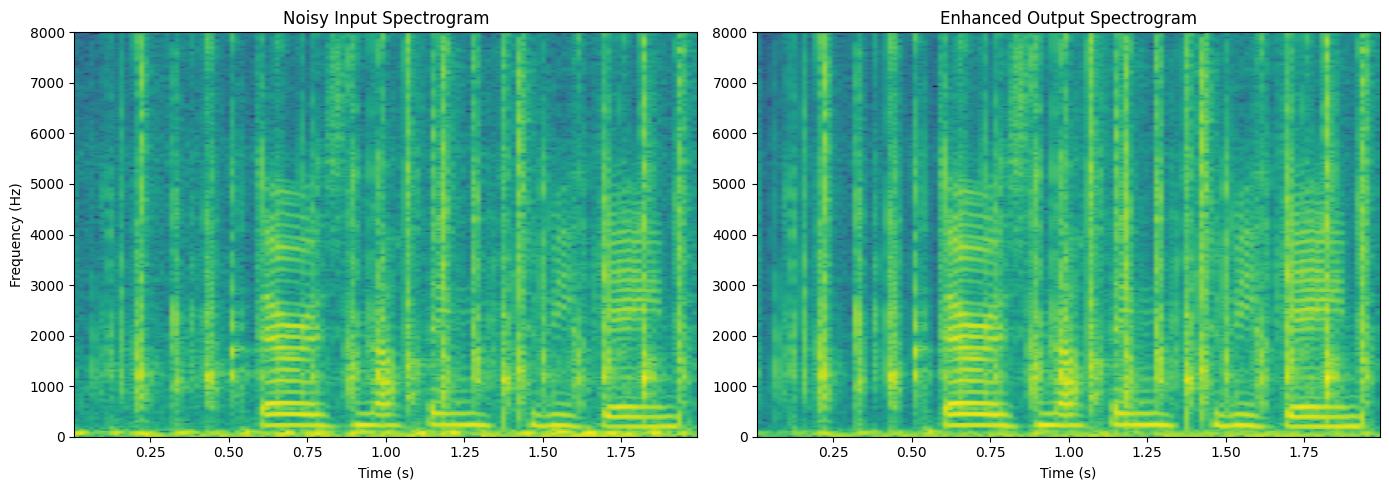

In [42]:
import matplotlib.pyplot as plt

# --- Part 1: Model Architecture Diagram ---
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.axis('off')

# Draw boxes for each block.
ax.text(0.1, 0.8, "Input Spectrogram", bbox=dict(facecolor='lightblue', edgecolor='black', boxstyle='round'),
        ha='center', va='center', fontsize=12)
ax.arrow(0.2, 0.8, 0.1, 0, head_width=0.03, head_length=0.03, fc='k', ec='k')

ax.text(0.45, 0.8, "Encoder\n(with Skip Connections)", bbox=dict(facecolor='lightgreen', edgecolor='black', boxstyle='round'),
        ha='center', va='center', fontsize=12)
ax.arrow(0.65, 0.8, 0.1, 0, head_width=0.03, head_length=0.03, fc='k', ec='k')

ax.text(0.85, 0.8, "LSTM Bottleneck", bbox=dict(facecolor='lightyellow', edgecolor='black', boxstyle='round'),
        ha='center', va='center', fontsize=12)

ax.arrow(0.85, 0.7, 0, -0.1, head_width=0.03, head_length=0.03, fc='k', ec='k')
ax.text(0.85, 0.55, "Decoder\n(with Skip Connections)", bbox=dict(facecolor='lightcoral', edgecolor='black', boxstyle='round'),
        ha='center', va='center', fontsize=12)
ax.arrow(0.75, 0.55, -0.1, 0, head_width=0.03, head_length=0.03, fc='k', ec='k')
ax.text(0.5, 0.55, "Output Spectrogram", bbox=dict(facecolor='lightgrey', edgecolor='black', boxstyle='round'),
        ha='center', va='center', fontsize=12)

ax.set_title("Model Architecture Diagram", fontsize=14)
plt.show()

# --- Part 2: Display Spectrograms of a Sample ---
# Display the spectrogram of the noisy input and the enhanced output side-by-side.
fig, axs = plt.subplots(1, 2, figsize=(14, 5))
axs[0].specgram(noisy_segment, NFFT=512, Fs=SAMPLE_RATE, noverlap=256, cmap='viridis')
axs[0].set_title("Noisy Input Spectrogram")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Frequency (Hz)")

axs[1].specgram(enhanced_segment, NFFT=512, Fs=SAMPLE_RATE, noverlap=256, cmap='viridis')
axs[1].set_title("Enhanced Output Spectrogram")
axs[1].set_xlabel("Time (s)")
plt.tight_layout()
plt.show()
